The purpose of this notebook is to investigate the statsmodel implementation of linear regression.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.formula.api as smf

import thinkplot
import thinkstats2

%matplotlib inline
sns.set()

# Read in bikeshare data

In [2]:
# read in data from a csv file
df = pd.read_csv('../Data/austin_bikeshare_trips.csv')

# Remove any trip with 0 minute duration
df = df[df['duration_minutes'] > 0]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

greater_than_2_hours = df[df['duration_minutes'] > 120]
frac_of_dataset = 100 * len(greater_than_2_hours) / len(df)

# Remove any trip lasting longer than 2 hours
df = df[df['duration_minutes'] <= 120]

# Reset the integer based index of the DataFrame
df.reset_index(drop=True, inplace=True)

df['start_time'] = pd.to_datetime(df['start_time'])

df['date'] = df['start_time'].dt.date

# Read in weather data

In [5]:
# read in data from a csv file
weather_df = pd.read_csv('../Data/austin_weather.csv')

# Replace values with NaNs
weather_df.replace('-', np.nan, inplace=True)
weather_df.replace('T', np.nan, inplace=True)

# Convert column types to float
for col in weather_df:
    if col != 'Date' and col != 'Events':
        weather_df[[col]] = weather_df[[col]].astype(float)
        
# Convert the column type to the datetime type
weather_df['Date'] = pd.to_datetime(weather_df['Date'])
# Set the index to that column
weather_df.index = weather_df['Date']

In [6]:
def get_merged_data(aggregation=None):
    """
    Return bikeshare data merged with weather data.
    
    aggregation: One of {None, 'mean', 'median'}
        Reduce the number of rows by performing some aggregation by day on the duration column.
    """
    if aggregation is None:
        _df = df[['date', 'duration_minutes']].copy()
        _df['date'] = pd.to_datetime(_df['date'])
        _df_weather = weather_df.copy()
        _df = _df.merge(_df_weather, how='left', left_on='date', right_on='Date')
    elif aggregation == 'mean':
        _df = df[['start_time', 'duration_minutes']].copy()
        _df.index = _df['start_time']
        _df = _df.resample('D').mean()
        _df = _df.join(weather_df)
    elif aggregation == 'median':
        _df = df[['start_time', 'duration_minutes']].copy()
        _df.index = _df['start_time']
        _df = _df.resample('D').median()
        _df = _df.join(weather_df)
    else:
        raise Error
        
    return _df

In [7]:
# Merge the two datasets
_df = get_merged_data(aggregation='mean')
# Drop rows for days that had no bike rides
_df = _df.dropna(subset=['duration_minutes'])

# Simple Linear Regression

Last week we used Allen Downey's implementation of Least Squares fit to perform our simple regression.

As a first step, let's use the statsmodel implementation to fit our regression parameters and see our model statistics.

In [8]:
formula = 'duration_minutes ~ TempHighF'
model = smf.ols(formula, data=_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       duration_minutes   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     45.63
Date:                Sat, 02 Dec 2017   Prob (F-statistic):           2.18e-11
Time:                        17:32:47   Log-Likelihood:                -3768.6
No. Observations:                1257   AIC:                             7541.
Df Residuals:                    1255   BIC:                             7551.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.0775      0.769     19.617      0.000      13.570      16.585
TempHighF      0.0629      0.009      6.755      0.000       0.045       0.081
==============================================================================
Omnibus:                       67.097   Durbin-Watson:                   0.960
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.040
Skew:                           0.605   Prob(JB):                     1.87e-17
Kurtosis:                       3.080   Cond. No.                         464.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
results.pvalues

Intercept    6.053860e-75
TempHighF    2.179892e-11
dtype: float64

In [11]:
np.std(results.resid)

4.8507456726598717

In [12]:
np.std(_df['duration_minutes'])

4.9381411380268059

In our model, we performed a linear regression using the *TempHighF* as our independent variable to predict *duration_minutes*. Our model had an $R^2$ value of .035, indicating low predictive power. However, the p-value associated with the intercept is 2.17e-11, indicating the slope is statistically significant. The p-value for the model itself is 2.18e-11, again indicating statistical significance.

# Multiple Regression

Let's compute the correlation between *duration_minutes* and the other variables in the DataFrame. Then, let's use variables with high correlation to perform multiple regression.

In [9]:
_df.corr().loc['duration_minutes']

duration_minutes              1.000000
TempHighF                     0.187304
TempAvgF                      0.163334
TempLowF                      0.127317
DewPointHighF                 0.126673
DewPointAvgF                  0.132159
DewPointLowF                  0.121939
HumidityHighPercent           0.036965
HumidityAvgPercent           -0.044935
HumidityLowPercent           -0.091646
SeaLevelPressureHighInches   -0.136702
SeaLevelPressureAvgInches    -0.117945
SeaLevelPressureLowInches    -0.097533
VisibilityHighMiles           0.056426
VisibilityAvgMiles            0.120896
VisibilityLowMiles            0.070379
WindHighMPH                  -0.024428
WindAvgMPH                   -0.039249
WindGustMPH                   0.014554
PrecipitationSumInches       -0.082092
Name: duration_minutes, dtype: float64

In [10]:
formula = 'duration_minutes ~ TempHighF + SeaLevelPressureHighInches'
model = smf.ols(formula, data=_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       duration_minutes   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     23.46
Date:                Sat, 02 Dec 2017   Prob (F-statistic):           9.93e-11
Time:                        17:37:23   Log-Likelihood:                -3759.5
No. Observations:                1254   AIC:                             7525.
Df Residuals:                    1251   BIC:                             7540.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     27.7916     32.388      0.858      0.391     -35.749      91.332
TempHighF                      0.0604      0.013      4.761      0.000       0.036       0.085
SeaLevelPressureHighInches    -0.4155      1.052     -0.395      0.693      -2.480       1.649
==============================================================================
Omnibus:                       67.097   Durbin-Watson:                   0.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.064
Skew:                           0.606   Prob(JB):                     1.84e-17
Kurtosis:                       3.080   Cond. No.                     2.07e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our $R^2$ value using *TempHighF* and *SeaLevelPressureHighInches* is .036, a marginal improvement over the simpler model. The p-value for  *SeaLevelPressureHighInches* also indicates the parameter for that variable may be due to chance.

In [11]:
formula = 'duration_minutes ~ TempHighF + VisibilityAvgMiles'
model = smf.ols(formula, data=_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       duration_minutes   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     26.93
Date:                Sat, 02 Dec 2017   Prob (F-statistic):           3.55e-12
Time:                        17:39:00   Log-Likelihood:                -3730.1
No. Observations:                1245   AIC:                             7466.
Df Residuals:                    1242   BIC:                             7482.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             13.2738      1.028     12.918      0.000      11.258      15.290
TempHighF              0.0580      0.010      5.909      0.000       0.039       0.077
VisibilityAvgMiles     0.2381      0.099      2.394      0.017       0.043       0.433
==============================================================================
Omnibus:                       68.172   Durbin-Watson:                   0.962
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               78.582
Skew:                           0.614   Prob(JB):                     8.63e-18
Kurtosis:                       3.076   Cond. No.                         622.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Substituting *VisibilityAvgMiles* for *SeaLevelPressureHighInches* yielded a higher $R^2$ value of .042. The p-value for the parameter associated with *VisibilityAvgMiles* is .017, just about statistically significant.

In [17]:
formula = 'duration_minutes ~ TempHighF + VisibilityAvgMiles + PrecipitationSumInches'
model = smf.ols(formula, data=_df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       duration_minutes   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     19.70
Date:                Thu, 30 Nov 2017   Prob (F-statistic):           1.88e-12
Time:                        16:21:13   Log-Likelihood:                -3380.6
No. Observations:                1133   AIC:                             6769.
Df Residuals:                    1129   BIC:                             6789.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 13.4012      1.139     11.767      0.000      11.167      15.636
TempHighF                  0.0620      0.010      6.070      0.000       0.042       0.082
VisibilityAvgMiles         0.1880      0.115      1.637      0.102      -0.037       0.413
PrecipitationSumInches    -0.4643      0.352     -1.318      0.188      -1.155       0.227
==============================================================================
Omnibus:                       56.425   Durbin-Watson:                   1.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               64.036
Skew:                           0.578   Prob(JB):                     1.24e-14
Kurtosis:                       2.862   Cond. No.                         673.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
results.pvalues

Intercept                 3.098050e-30
TempHighF                 1.746124e-09
VisibilityAvgMiles        1.020118e-01
PrecipitationSumInches    1.877461e-01
dtype: float64

In [21]:
np.std(results.resid)

4.7818297089791617

If we regress on *TempHighF*, *VisibilityAvgMiles*, and *PrecipitationSumInches*, our model achieves a higher $R^2$ of .05. However, this model still has low predictive power. In this case, the parameters for the latter 2 variables are not statistically significant.

If we wish to take a data mining approach to the problem, we can iteratively create models by regressing on each variable one-by-one, computing R^2, and taking the top model. Then, we can create a new model by iteratively adding another variable to the top performing model, computing $R^2$, and ranking these. If $R^2$ stops improving, we take the best model we've computed so far.

Here's code performing this technique, which is called [feature subset selection](https://en.wikipedia.org/wiki/Feature_selection).

In [13]:
_df.columns

Index(['duration_minutes', 'Date', 'TempHighF', 'TempAvgF', 'TempLowF',
       'DewPointHighF', 'DewPointAvgF', 'DewPointLowF', 'HumidityHighPercent',
       'HumidityAvgPercent', 'HumidityLowPercent',
       'SeaLevelPressureHighInches', 'SeaLevelPressureAvgInches',
       'SeaLevelPressureLowInches', 'VisibilityHighMiles',
       'VisibilityAvgMiles', 'VisibilityLowMiles', 'WindHighMPH', 'WindAvgMPH',
       'WindGustMPH', 'PrecipitationSumInches', 'Events'],
      dtype='object')

In [71]:
# Columns to try for regression
cols = [c for c in _df if c not in ['duration_minutes', 'Date', 'Events']]

is_done = False
used_cols = {}
prev_r_squared = -1

while not is_done:
    r_squared = []
    
    for col in cols:
        if col in used_cols:
            continue
            
        new_formula = 'duration_minutes ~ ' + ' + '.join(used_cols.keys()) + ' + {}'.format(col)
        model = smf.ols(new_formula, data=_df)
        results = model.fit()
        r_squared.append((col, results.rsquared))

    r_squared = sorted(r_squared, key=lambda x:x[1], reverse=True)
    
    if r_squared:
        if r_squared[0][1] > prev_r_squared:
            prev_r_squared = r_squared[0][1]
            used_cols[r_squared[0][0]] = None
            print('New variable and R^2: {}'.format(r_squared[0]))
        else:
            print('R**2 has stopped improving. Stopping.')
            is_done = True
    else:
        print('Used all variables! Stopping')
        is_done = True

New variable and R^2: ('TempHighF', 0.035082877673165758)
New variable and R^2: ('PrecipitationSumInches', 0.04661301066096224)
New variable and R^2: ('TempLowF', 0.052506323093205243)
New variable and R^2: ('DewPointAvgF', 0.058075063147467798)
New variable and R^2: ('VisibilityAvgMiles', 0.061298771197682234)
New variable and R^2: ('WindGustMPH', 0.0628146368124326)
New variable and R^2: ('WindHighMPH', 0.06836884269054011)
New variable and R^2: ('DewPointHighF', 0.070260606745312537)
New variable and R^2: ('HumidityLowPercent', 0.071331473083886987)
New variable and R^2: ('VisibilityLowMiles', 0.072343844551244429)
New variable and R^2: ('SeaLevelPressureHighInches', 0.072957704466397821)
New variable and R^2: ('SeaLevelPressureAvgInches', 0.076111723404588938)
New variable and R^2: ('HumidityHighPercent', 0.07649027615345616)
New variable and R^2: ('HumidityAvgPercent', 0.077127012540709194)
New variable and R^2: ('VisibilityHighMiles', 0.077458612069521648)
New variable and R^2: (

In [75]:
prev_r_squared

0.077825835470599514

In [76]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       duration_minutes   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     4.935
Date:                Sat, 02 Dec 2017   Prob (F-statistic):           2.50e-11
Time:                        18:17:04   Log-Likelihood:                -3356.3
No. Observations:                1131   AIC:                             6753.
Df Residuals:                    1111   BIC:                             6853.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     30.2489     38.563      0.784      0.433     -45.415     105.913
TempHighF                     -0.0208      0.277     -0.075      0.940      -0.564       0.522
PrecipitationSumInches        -0.4612      0.381     -1.211      0.226      -1.208       0.286
TempLowF                      -0.2510      0.277     -0.906      0.365      -0.795       0.293
DewPointAvgF                   0.1956      0.102      1.909      0.057      -0.005       0.397
VisibilityAvgMiles             0.2704      0.184      1.466      0.143      -0.091       0.632
WindGustMPH                    0.2196      0.069      3.174      0.002       0.084       0.355
WindHighMPH                   -0.2989      0.117     -2.563      0.011      -0.528      -0.070
DewPointHighF                 -0.0500      0.058     -0.865      0.387      -0.164       0.064
HumidityLowPercent            -0.1264      0.116     -1.087      0.277      -0.355       0.102
VisibilityLowMiles            -0.0613      0.073     -0.837      0.403      -0.205       0.082
SeaLevelPressureHighInches    -9.8293      5.141     -1.912      0.056     -19.917       0.258
SeaLevelPressureAvgInches     10.6373      8.862      1.200      0.230      -6.750      28.025
HumidityHighPercent           -0.1168      0.118     -0.993      0.321      -0.348       0.114
HumidityAvgPercent             0.1998      0.229      0.874      0.382      -0.249       0.648
VisibilityHighMiles            0.5269      0.851      0.619      0.536      -1.142       2.196
WindAvgMPH                    -0.0548      0.104     -0.526      0.599      -0.259       0.150
TempAvgF                       0.1769      0.546      0.324      0.746      -0.894       1.248
SeaLevelPressureLowInches     -1.4016      5.040     -0.278      0.781     -11.291       8.488
DewPointLowF                  -0.0100      0.053     -0.189      0.850      -0.114       0.094
==============================================================================
Omnibus:                       51.884   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.083
Skew:                           0.537   Prob(JB):                     4.02e-13
Kurtosis:                       2.758   Cond. No.                     5.69e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.69e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Interesting. Our best performing model in terms of $R^2$ used all of the variables contained within the DataFrame! We achieved an $R^2$ of .078, which is still very low in terms of predictive power. While the p-value associated with our model is statistically significant, few variables have statistically significant slopes.

# Bonus

Here are some cool ways to visualize scatter plots and distributions for multiple variables within a dataset.

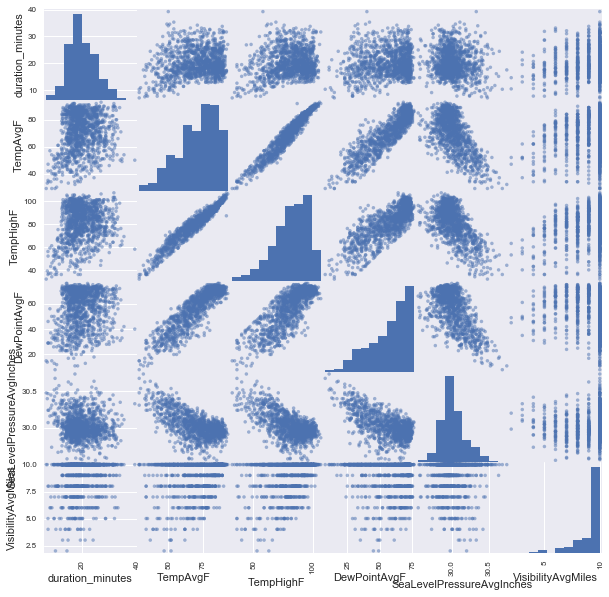

In [77]:
pd.plotting.scatter_matrix(_df[['duration_minutes', 'TempAvgF', 'TempHighF', 'DewPointAvgF', 'SeaLevelPressureAvgInches', 'VisibilityAvgMiles']],
                       figsize=(10,10))
plt.show()

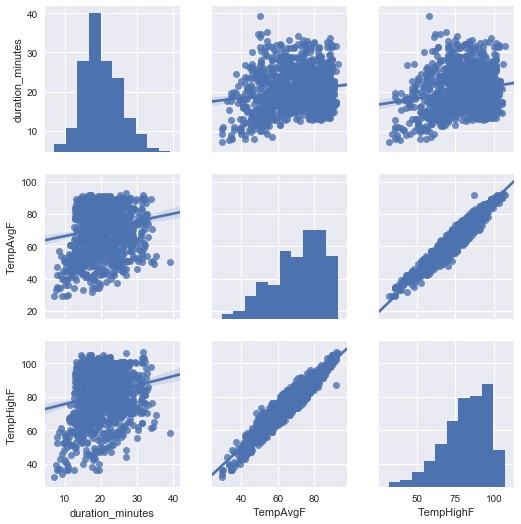

In [27]:
sns.pairplot(_df, vars=['duration_minutes', 'TempAvgF', 'TempHighF'], kind='reg')

The Seaborn method also automatically plots the least squares line in the scatter plots.